In [1]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.analytical_field import get_analytic_b_field

from rtmag.test.eval_plot import plot_sample, plot_validation

from rtmag.test.eval import evaluate

from tqdm import tqdm
from torch.optim import Adam
import gc
from rtmag.train.diff_torch_batch import curl, divergence
from torchmetrics.regression import ConcordanceCorrCoef, MeanSquaredError

In [2]:
b_cube = get_analytic_b_field(n=1, m=1, l=0.3, psi=np.pi / 4).astype(np.float32)

In [3]:
b_cube.shape

(64, 64, 64, 3)

In [4]:
b_bottom = b_cube[:, :, 0, :]
b_bottom.shape

(64, 64, 3)

(512, 256, 3)


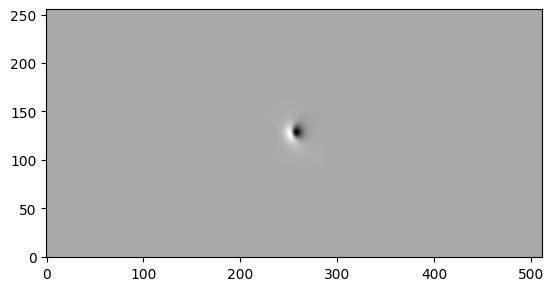

In [5]:
b_bottom_padding = np.pad(b_bottom, pad_width=[(224, 224), (96, 96), (0, 0)], mode='constant', constant_values=0)
print(b_bottom_padding.shape)
plt.imshow(b_bottom_padding[:, :, 2].T, origin='lower', cmap='gray')

In [6]:
b_bottom_padding[224:512-224, 96:256-96, :].shape

(64, 64, 3)

In [7]:
np.allclose(b_bottom_padding[224:512-224, 96:256-96, :], b_bottom)

True

In [8]:
meta_path = Path("/home/usr/workspace/base/uno_pi_cc_hnorm_1_unit_aug_ccc_square")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

# b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
model_input = b_bottom_padding
model_input = model_input[None, :, :, None, :]
b_norm = np.max(np.abs(model_input))
print(b_norm)
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

293.32474


torch.Size([1, 1, 256, 512, 3])

In [10]:
labels = model(model_input).detach()
labels.shape

torch.Size([1, 256, 256, 512, 3])

In [11]:
model = model.train()
optimizer = Adam(model.parameters(), lr=args.training['learning_late'])

with tqdm(range(20)) as tqdm_loader_train:
        for iteration in tqdm_loader_train:
                gc.collect()
                torch.cuda.empty_cache()

                loss = {}
                # [b, z, y, x, 3] 
                outputs = model(model_input).to(device)

                # [b, z, y, x, 3] -> [b, z, ...]
                opts = torch.flatten(outputs, start_dim=2)
                lbls = torch.flatten(labels, start_dim=2)

                # [b, z, ...] -> [b, ..., z]
                opts = torch.permute(opts, (0, 2, 1))
                lbls = torch.permute(lbls, (0, 2, 1))

                # mse loss
                mse = MeanSquaredError().to(device)
                loss_mse = torch.mean(mse(opts.flatten(), lbls.flatten()))
                loss['mse'] = loss_mse

                # ccc loss
                # ccc = ConcordanceCorrCoef(num_outputs=opts.shape[-1]).to(device)
                # loss_ccc = 0.0
                # if args.training.get('ccc_square', False):
                #         for i in range(opts.shape[0]):
                #                 loss_ccc += torch.mean(torch.square(1.0 - ccc(opts[i], lbls[i])))
                # else:
                #         for i in range(opts.shape[0]):
                #                 loss_ccc += torch.mean(torch.abs(1.0 - ccc(opts[i], lbls[i])))
                # loss_ccc /= opts.shape[0]
                # loss['ccc'] = loss_ccc
                
                # [b, z, y, x, 3] -> [b, x, y, z, 3]
                b = torch.permute(outputs, (0, 3, 2, 1, 4))
                B = torch.permute(labels, (0, 3, 2, 1, 4))


                # unnormalization
                if args.data["dataset_name"] == "Hnorm_Square_Unit_Aug":
                        divisor = (1 / np.arange(1, b.shape[2] + 1)**2 ).reshape(1, 1, -1, 1).astype(np.float32)
                else:
                        divisor = (1 / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1).astype(np.float32)
                        
                divisor = torch.from_numpy(divisor).to(device)
                b = b * divisor
                B = B * divisor
                
                # boundary condition loss
                loss_bc = 0.0
                # bottom (z=0)
                loss_bc += torch.mean(torch.square(b[:, :, :, 0, :] - B[:, :, :, 0, :]))
                loss['bc'] = loss_bc

                dx = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)
                dy = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)
                dz = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)

                # force-free loss
                bx, by, bz = b[..., 0], b[..., 1], b[..., 2]
                jx, jy, jz = curl(bx, by, bz, dx, dy, dz)
                b = torch.stack([bx, by, bz], -1)
                j = torch.stack([jx, jy, jz], -1)

                jxb = torch.cross(j, b, -1)
                loss_ff = (jxb**2).sum(-1) / ((b**2).sum(-1) + 1e-7)
                loss_ff = torch.mean(loss_ff)
                loss['ff'] = loss_ff

                # divergence-less loss
                div_b = divergence(bx, by, bz, dx, dy, dz)
                loss_div = torch.mean(torch.square(div_b))
                loss['div'] = loss_div


                los = 0.01*args.training['w_mse']*loss['mse'] \
                + args.training['w_bc']*loss['bc'] \
                + 100*args.training['w_ff']*loss['ff'] \
                + 100*args.training['w_div']*loss['div'] \
                
                print(f"iter:{iteration}, loss:{los.item():2g}, mse:{loss_mse.item():.2g}, bc:{loss_bc.item():.2g}, ff:{loss_ff.item():.2g}, div:{loss_div.item():.2g}")

                optimizer.zero_grad()
                los.backward()
                optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]

iter:0, loss:7.80047e-05, mse:0, bc:0, ff:4e-07, div:3.8e-07


  5%|▌         | 1/20 [00:01<00:26,  1.37s/it]

iter:1, loss:6.62506e-05, mse:0.0001, bc:2e-06, ff:2.1e-07, div:2.5e-07


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

iter:2, loss:4.68778e-05, mse:0.00054, bc:2.7e-07, ff:1.7e-07, div:2.1e-07


 15%|█▌        | 3/20 [00:03<00:17,  1.03s/it]

iter:3, loss:4.25702e-05, mse:0.00019, bc:5.1e-07, ff:1.7e-07, div:1.9e-07


 20%|██        | 4/20 [00:04<00:16,  1.01s/it]

iter:4, loss:3.83126e-05, mse:0.00012, bc:1.3e-07, ff:1.7e-07, div:1.9e-07


 25%|██▌       | 5/20 [00:05<00:14,  1.00it/s]

iter:5, loss:4.32642e-05, mse:0.00025, bc:3.3e-07, ff:1.8e-07, div:2e-07


 30%|███       | 6/20 [00:06<00:13,  1.03it/s]

iter:6, loss:3.77287e-05, mse:9.5e-05, bc:4.5e-08, ff:1.7e-07, div:1.9e-07


 35%|███▌      | 7/20 [00:06<00:12,  1.07it/s]

iter:7, loss:4.00328e-05, mse:0.00015, bc:3.8e-07, ff:1.7e-07, div:1.8e-07


 40%|████      | 8/20 [00:07<00:11,  1.09it/s]

iter:8, loss:4.04306e-05, mse:0.00022, bc:3.6e-07, ff:1.7e-07, div:1.7e-07


 45%|████▌     | 9/20 [00:08<00:09,  1.11it/s]

iter:9, loss:3.79733e-05, mse:0.00016, bc:1.4e-07, ff:1.8e-07, div:1.7e-07


 50%|█████     | 10/20 [00:09<00:08,  1.12it/s]

iter:10, loss:3.59479e-05, mse:7.3e-05, bc:1.1e-07, ff:1.7e-07, div:1.7e-07


 55%|█████▌    | 11/20 [00:11<00:11,  1.31s/it]

iter:11, loss:3.30896e-05, mse:5.9e-05, bc:5.9e-08, ff:1.6e-07, div:1.6e-07


 60%|██████    | 12/20 [00:12<00:09,  1.24s/it]

iter:12, loss:3.09019e-05, mse:0.00012, bc:1.6e-08, ff:1.4e-07, div:1.6e-07


 65%|██████▌   | 13/20 [00:13<00:08,  1.17s/it]

iter:13, loss:3.06979e-05, mse:0.00016, bc:8.6e-08, ff:1.3e-07, div:1.5e-07


 70%|███████   | 14/20 [00:14<00:06,  1.13s/it]

iter:14, loss:3.02989e-05, mse:0.00012, bc:1.3e-07, ff:1.3e-07, div:1.5e-07


 75%|███████▌  | 15/20 [00:16<00:05,  1.11s/it]

iter:15, loss:2.83543e-05, mse:6.1e-05, bc:3.3e-08, ff:1.2e-07, div:1.5e-07


 80%|████████  | 16/20 [00:17<00:04,  1.07s/it]

iter:16, loss:2.73596e-05, mse:1.6e-05, bc:2.8e-08, ff:1.2e-07, div:1.5e-07


 85%|████████▌ | 17/20 [00:17<00:03,  1.03s/it]

iter:17, loss:2.81413e-05, mse:2.7e-05, bc:1.4e-07, ff:1.2e-07, div:1.5e-07


 90%|█████████ | 18/20 [00:18<00:02,  1.01s/it]

iter:18, loss:2.81823e-05, mse:6.4e-05, bc:1.3e-07, ff:1.2e-07, div:1.4e-07


 95%|█████████▌| 19/20 [00:19<00:00,  1.01it/s]

iter:19, loss:2.75251e-05, mse:9.8e-05, bc:4.4e-08, ff:1.2e-07, div:1.4e-07


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


In [12]:
model_output = model(model_input)

In [13]:
model_output.shape

torch.Size([1, 256, 256, 512, 3])

In [14]:
bb = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, bb.shape[2] + 1)).reshape(1, 1, -1, 1)
bb = bb * divi

In [15]:
bb.shape

(512, 256, 256, 3)

In [16]:
b = bb[224:512-224, 96:256-96, :64, :]

In [17]:
b.shape

(64, 64, 64, 3)

In [18]:
evaluate(b, b_cube)

C_vec     : 0.9506
C_cs      : 0.6884
E_n'      : 0.5338
E_m'      : 0.3687
eps       : 0.6705
CW_sin    : 0.6242
L_f       : 0.9548
L_d       : 1.1869
l2_err    : 0.3373


{'C_vec': 0.9505540706231783,
 'C_cs': 0.6884217830008892,
 "E_n'": 0.533810711294974,
 "E_m'": 0.3686523163423523,
 'eps': 0.6705065988495993,
 'CW_sin': 0.6242104882169319,
 'L_f': 0.9547705639925403,
 'L_d': 1.1869483932685247,
 'l2_err': 0.33734035561823245}

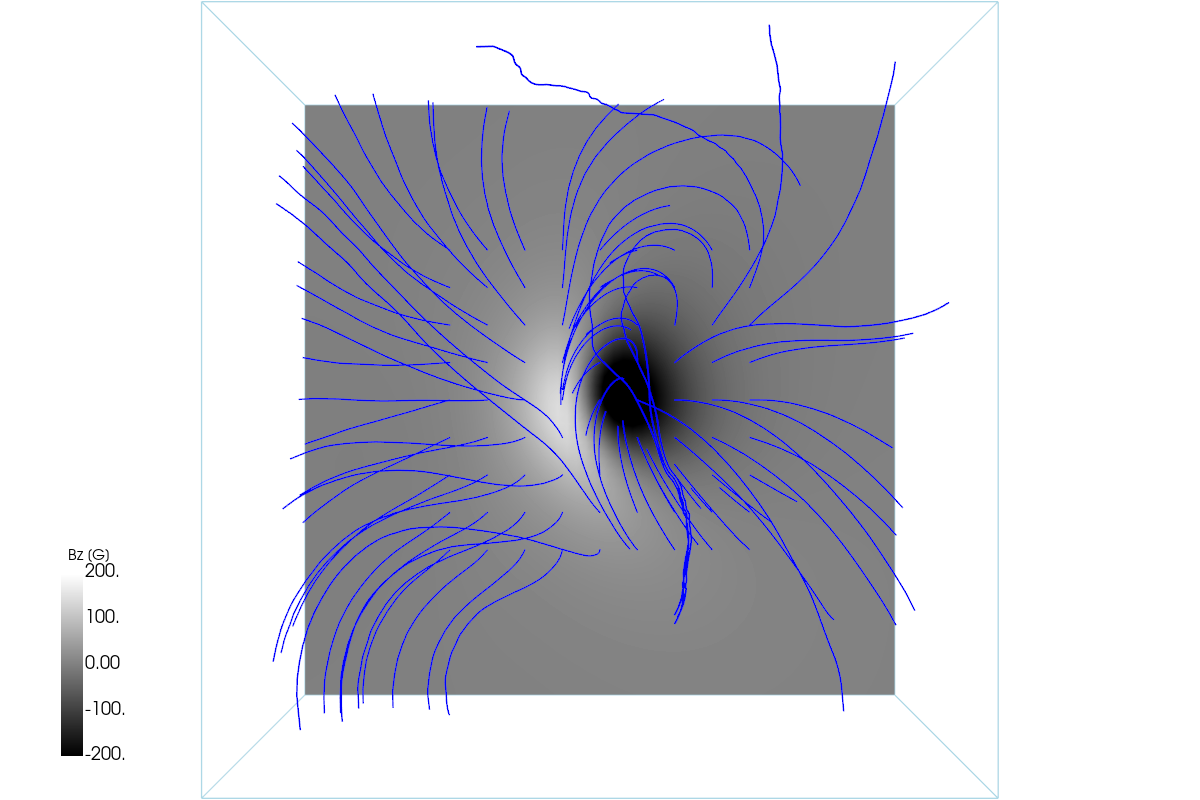

In [19]:
vmin = -200
vmax = 200
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

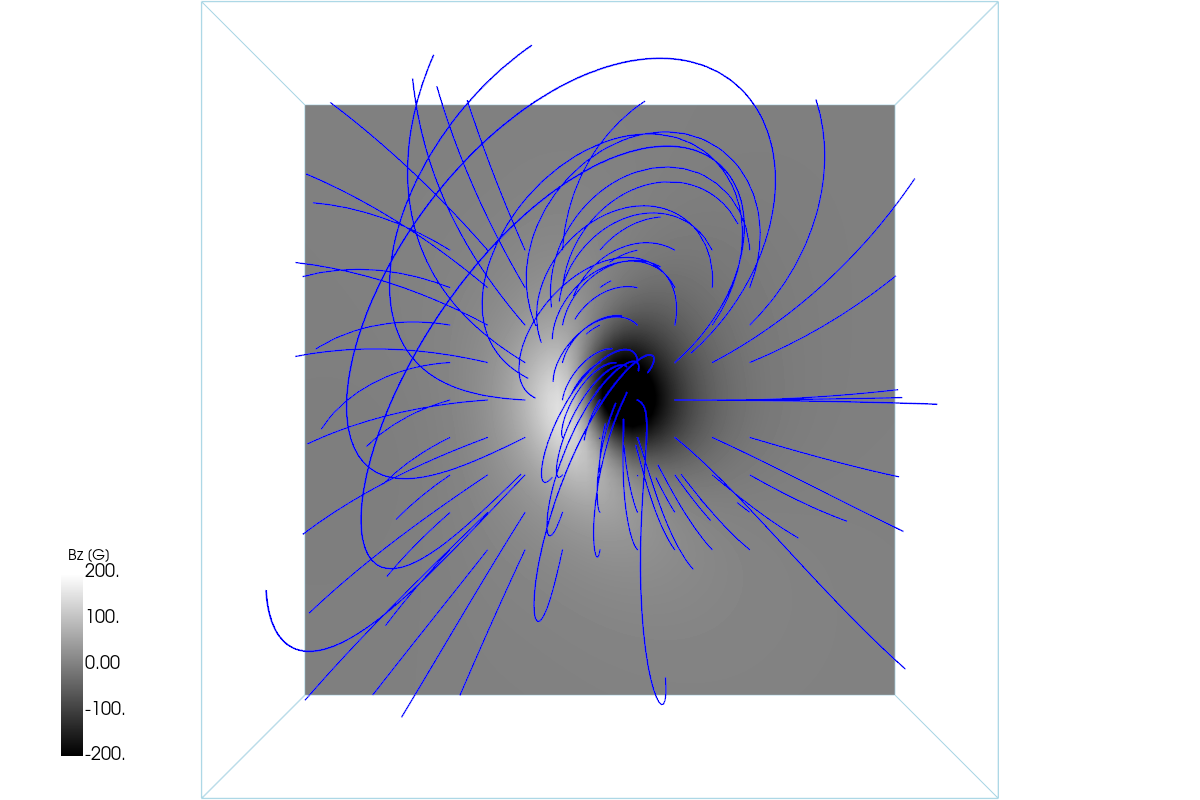

In [20]:
vmin = -200
vmax = 200
i_siz=b_cube.shape[0] / 2
j_siz=b_cube.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b_cube[..., 0]
by = b_cube[..., 1]
bz = b_cube[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

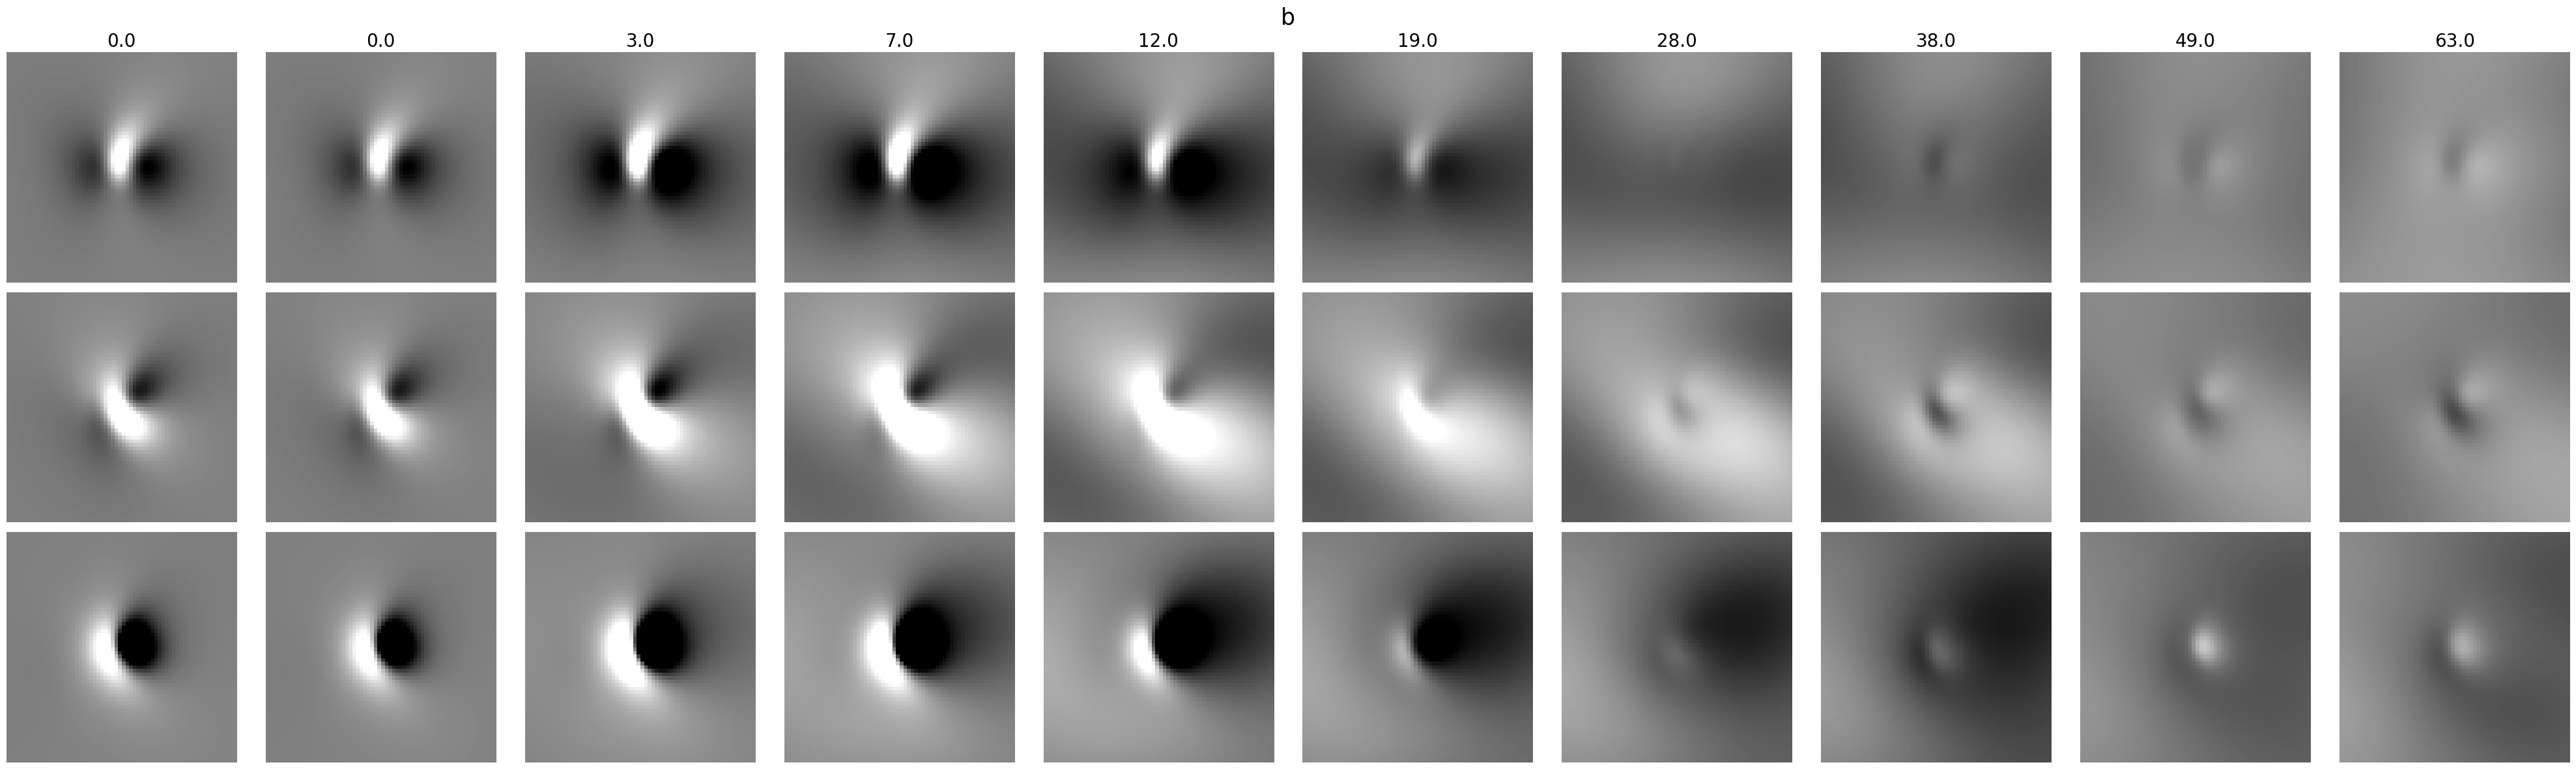

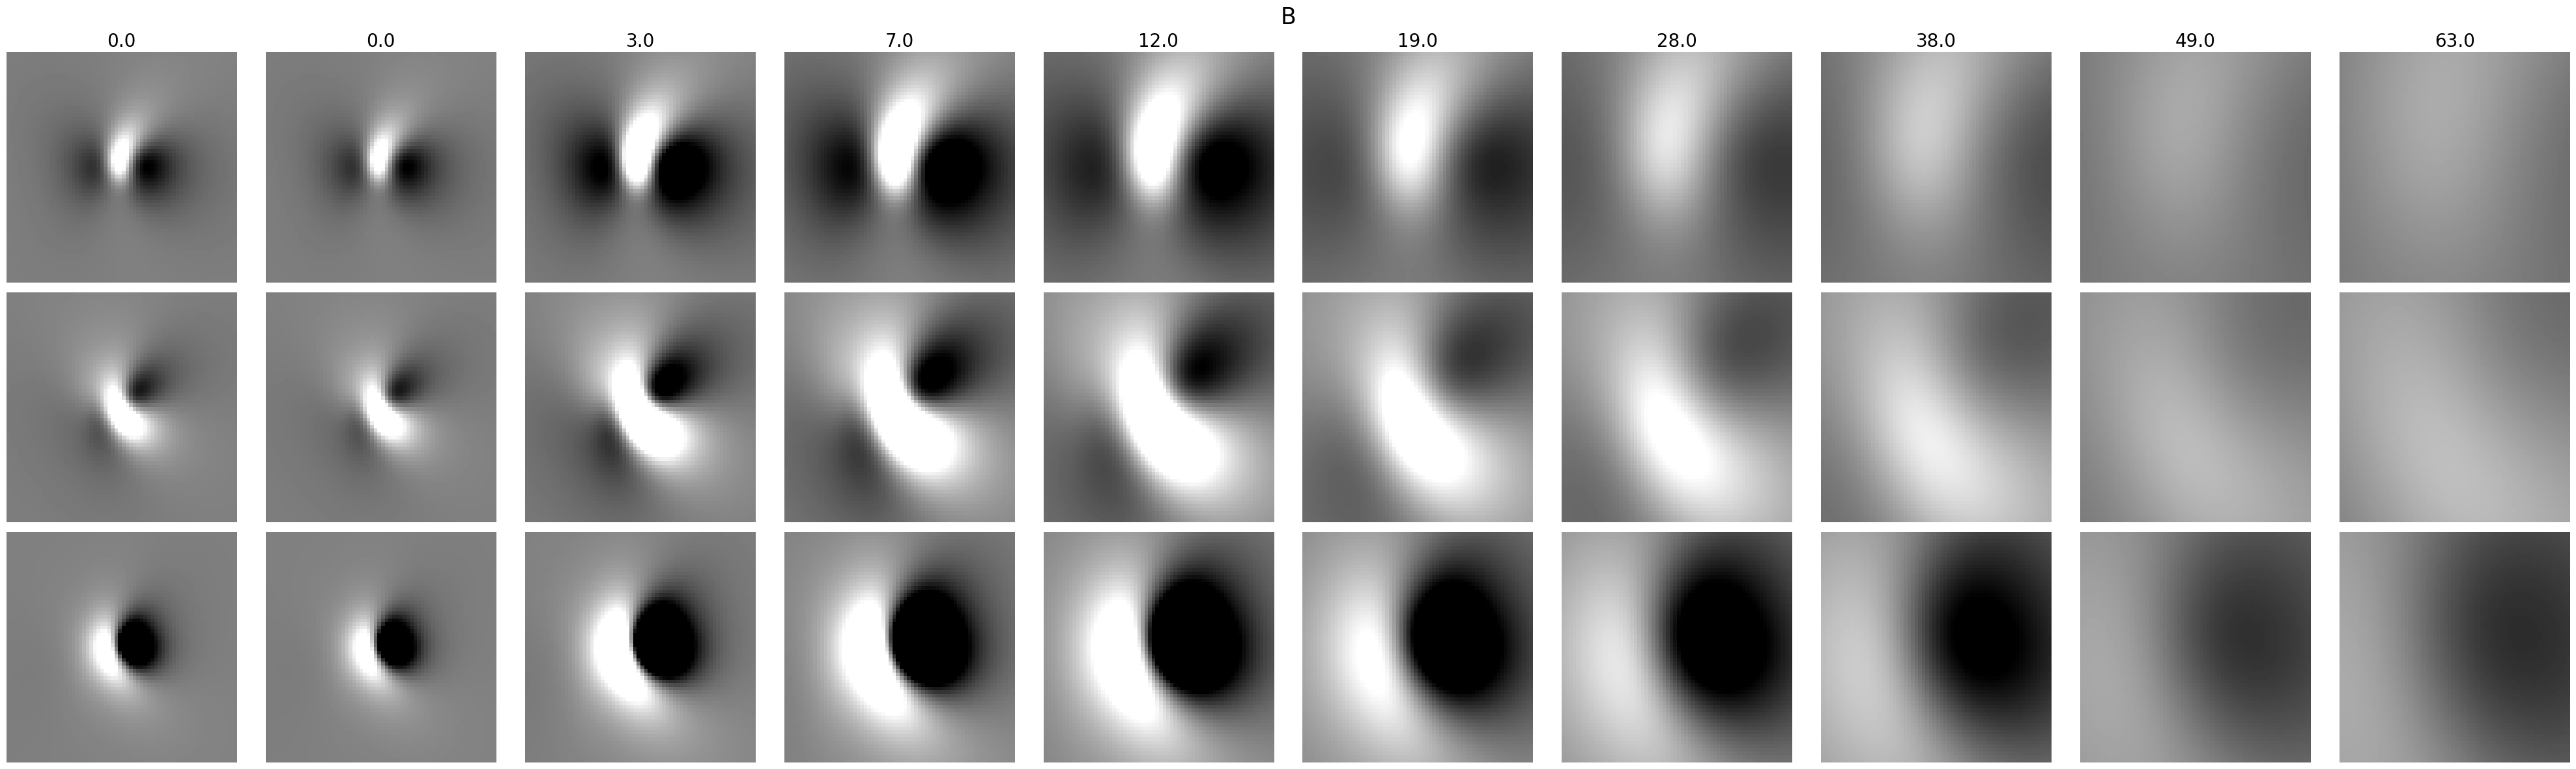

In [21]:
plot_sample(b, b_cube, v_mm=100)

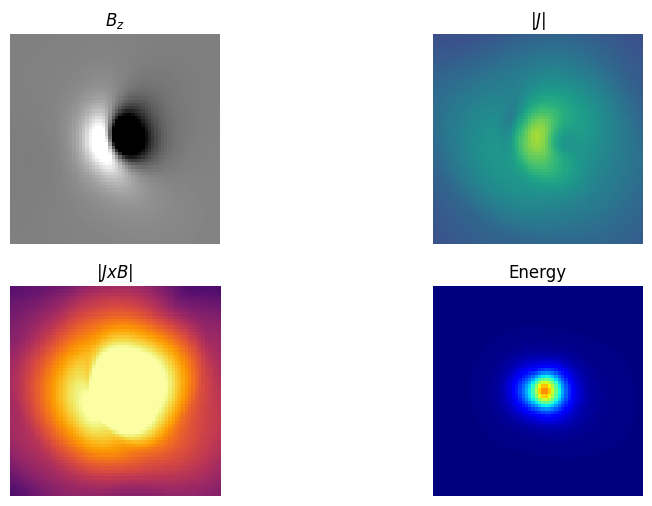

In [22]:
plot_validation(b, b_mm = [-100, 100], j_mm = [1, 1e3], jxb_mm = [1, 1e3], e_mm = [0, 1e4])

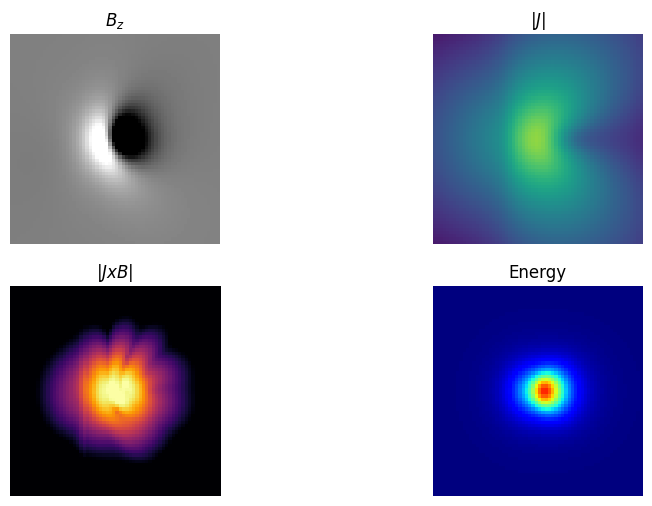

In [23]:
plot_validation(b_cube, b_mm = [-100, 100], j_mm = [1, 1e3], jxb_mm = [1, 1e3], e_mm = [0, 1e4])